In [1]:
import os
import numpy as np
import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Binarizer
from time import time
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim

from torch.utils.tensorboard import SummaryWriter

from functools import reduce

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Dataloader + downloading dataset

In [2]:
DOWNLOAD = False
TRAIN_VAL_SPLIT = 0.9
batch_size = 64

root = './resources/mnist'
if not os.path.exists(root):
    os.mkdir(root)
    
transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize((0.0,), (1.0,))
                               ])

# Flatten the images into a vector
flatten = lambda x: transforms.ToTensor()(x).view(28**2)

full_train_set = datasets.MNIST(root=root, download=DOWNLOAD, train=True, transform=transform)
test_set = datasets.MNIST(root=root, download=DOWNLOAD, train=False, transform=transform)

num_full_train = len(full_train_set)
train_size = int(TRAIN_VAL_SPLIT * num_full_train)
val_size = num_full_train - train_size
train_set, val_set = torch.utils.data.random_split(full_train_set, [train_size, val_size])

# The digit classes to use
classes = [0,1,2,3,4,5,6,7,8,9]

def get_labeled_indices(labels, classes, n_each=10):
    labeled_indices = []
    for c in classes:
        # get first N indices of a given label
        labeled_indices.extend(list(np.asarray(reduce(lambda x, y: x | y, [labels.numpy() == c])).nonzero()[0][:n_each]))

    labeled_indices = np.array(labeled_indices)
    np.random.shuffle(labeled_indices)
    return labeled_indices

def stratified_sampler(labels, excluded_indices=np.array([], dtype=bool)):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    
    mask = np.ones(len(indices), dtype=bool)
    if excluded_indices.size != 0:
        mask[excluded_indices] = False
    
    indices = indices[mask]
    np.random.shuffle(indices)  # in-place shuffling
    indices = torch.from_numpy(indices[mask,...])
    return SubsetRandomSampler(indices)

labeled_indices = get_labeled_indices(full_train_set.train_labels, classes, n_each=10)

train_loader = torch.utils.data.DataLoader(dataset=full_train_set,
                                           batch_size=batch_size,
                                           sampler=stratified_sampler(full_train_set.train_labels),
#                                            shuffle=True
                                          )

val_loader = torch.utils.data.DataLoader(dataset=test_set,
                                         batch_size=batch_size,
#                                          sampler=stratified_sampler(test_set.test_labels),
                                         shuffle=True
                                        )

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size,
                                          sampler=stratified_sampler(test_set.test_labels)
#                                           shuffle=False
                                         )

print('Training samples: {}'.format(len(train_set)))
print('Validation samples: {}'.format(len(val_set)))
print('Test samples: {}'.format(len(test_set)))
print(len(train_loader))

Training samples: 54000
Validation samples: 6000
Test samples: 10000
938


/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [3]:
len(train_set.indices), len(train_loader)

(54000, 938)

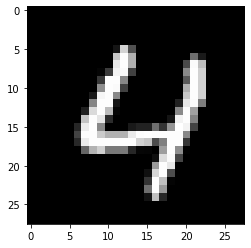

In [4]:
pom, _ = next(iter(train_loader))
pom.shape
plt.imshow(pom[0].view(28,28).numpy(), cmap='gist_gray')

## Inspecting the first iteration of images and labels

In [5]:
# get iteration of images and labels to find out its shape
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [6]:
# Minimum and maximum value in the first image (pixel range)
min(images[0].view(-1)), max(images[0].view(-1))

(tensor(0.), tensor(1.))

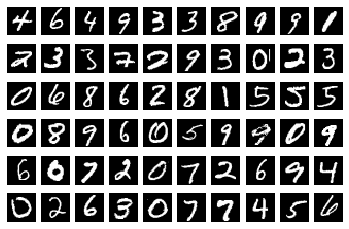

In [7]:
# display 60 images from current iteration
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gist_gray')

# M1 implementation

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

num_features = 28*28
latent_features = 50

class VAE(nn.Module):
    
    def __init__(self, latent_features=50):
        super(VAE, self).__init__()
        
        self.latent_features = latent_features
        
        self.encoder = nn.Sequential(
            nn.Linear(num_features, 600),
            nn.Softplus(),
            nn.Linear(600, 600),
            nn.Softplus(),
            nn.Linear(600, 2*latent_features)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_features, 600),
            nn.Softplus(),
            nn.Linear(600, 600),
            nn.Softplus(),
            nn.Linear(600, num_features)
        )
        
    def reparametrization_trick(self, mu, log_var):
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, self.latent_features).to(device)
        # log(sigma^2) = log_var  =>  e^(log_var) = sigma^2  =>  sigma = e^(log_var / 2)
        sigma = torch.exp(log_var / 2)
        z = mu + sigma * epsilon
        return z
    
    def get_z(self, x):
        mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)
        return mu
        
    def forward(self, x):
        initial_shape = x.shape
        x = x.view(initial_shape[0], -1)  # flatten the input
        mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)
        # Make sure that the log variance is positive
        log_var = F.softplus(log_var)
        z = self.reparametrization_trick(mu, log_var)  # sample from mu + sigma * epsilon, where epsilon ~ N(0,1)
        
        outputs = F.sigmoid(self.decoder(z))
        outputs = outputs.view(initial_shape)
        return outputs, mu, log_var, z
    
net = VAE(latent_features=latent_features).to(device)
print(net)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=600, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=600, out_features=600, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=600, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=600, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=600, out_features=600, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=600, out_features=784, bias=True)
  )
)


In [11]:
import torch.optim as optim

def ELBO_loss(x_hat, x, mu, log_var, bernoulli=False):
    
    #TODO: add discretization for use with Bernoulli
    if bernoulli:
        threshold = torch.tensor([0.2])
        x = (x > threshold).float()
    
    likelihood_batch = -F.binary_cross_entropy(x_hat, x, reduction='none') # dimension [batch, [orig_image_dims]]
    # Sum over features
    likelihood_batch = likelihood_batch.view(likelihood_batch.size(0), -1).sum(1)
    
    # KL-divergence = how much information is lost by approximating p(z) by q(z)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)
    
    # the evidence lower bound objective (ELBO)
    # use mean over batch
    elbo = torch.mean(likelihood_batch) - torch.mean(kl)
    return -elbo, kl.sum()

# loss_function = nn.MSELoss()
loss_function = ELBO_loss
optimizer = optim.Adam(net.parameters(), lr=0.001)

### Test the forward pass

In [98]:
# test the forward pass
images, labels = next(iter(train_loader))
images = images.to(device)
print(images.shape)
outputs, mu, log_var, z = net(images)
print(outputs.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])


In [99]:
# min and max value of output images (pixel values)
min(outputs.view(-1)), max(outputs.view(-1))

(tensor(0.1922, grad_fn=<SelectBackward>),
 tensor(0.8734, grad_fn=<SelectBackward>))

In [100]:
# Example loss function and output dimensions
loss, kl = loss_function(outputs, images, mu, log_var, bernoulli=True)
print('log var shape:', log_var.shape)
print('mu shape:', mu.shape)
print('loss value:', loss)
print('kl value', kl)

log var shape: torch.Size([64, 50])
mu shape: torch.Size([64, 50])
loss value: tensor(581.9085, grad_fn=<NegBackward>)
kl value tensor(872.8195, grad_fn=<SumBackward0>)


### Save batch of images and network graph to file for displaying in tensorboard

In [20]:
# Save batch of images and network graph to file for displaying in tensorboard
tb = SummaryWriter()

network = Net()
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
tb.add_graph(network, images)
tb.close()

/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/torch/jit/__init__.py:914: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%epsilon : Float(64, 2) = aten::randn_like(%log_var, %52, %53, %54, %55), scope: Net # <ipython-input-15-10143e950f0f>:26:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  check_tolerance, _force_outplace, True, _module_class)
/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/torch/jit/__init__.py:914: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[54, 0, 8, 7] (0.7348414659500122 vs. 0.16779620945453644) and 50166 other locations (99.00%)
  check_tolerance, _force_outplace, True, _module_class)
/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/torch/jit/__init__.py:

## Train the VAE

In [101]:
from IPython.display import Image, display, clear_output
from sklearn.decomposition import PCA
# train the network
TF_LOG = False
BERNOULLI = False
train_loss, train_kl = [], []
valid_loss, valid_kl = [], []

print("Using device:", device)

if TF_LOG:
    tb = SummaryWriter()

for epoch in range(10):
    batch_loss, batch_kl = [], []
    net.train()
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # forward + backward + optimize
        x_hat, mu, log_var, _ = net(inputs)
        loss, kl = loss_function(x_hat, inputs, mu, log_var, bernoulli=BERNOULLI)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        batch_kl.append(kl.item())
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))
    
    with torch.no_grad():
        net.eval()
        batch_loss, batch_kl = [], []
        
#         for data in test_loader:
        data = next(iter(test_loader))
        inputs, labels = data[0].to(device), data[1].to(device)

        x_hat, mu, log_var, z = net(inputs)

        loss, kl = loss_function(x_hat, inputs, mu, log_var, bernoulli=BERNOULLI)
        batch_loss.append(loss.item())
        batch_kl.append(kl.item())
            
        valid_loss.append(np.mean(batch_loss))
        valid_kl.append(np.mean(batch_kl))
        
        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        inputs = inputs.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()
    
    if TF_LOG:
        tb.add_scalar('Training loss', train_loss[-1], epoch)
        tb.add_scalar('Training KL divergence', train_kl[-1], epoch)
        tb.add_scalar('Validation loss', valid_loss[-1], epoch)
        tb.add_scalar('Validation KL divergence', valid_kl[-1], epoch)


if TF_LOG:
    tb.close()
# print('Finished training!')

Using device: cpu
[1,   100] loss: 214.625
[1,   200] loss: 195.383
[1,   300] loss: 191.392
[1,   400] loss: 180.175
[1,   500] loss: 168.616
[1,   600] loss: 161.499
[1,   700] loss: 158.906
[1,   800] loss: 156.680
[1,   900] loss: 154.825
[2,   100] loss: 153.795
[2,   200] loss: 152.436
[2,   300] loss: 151.835
[2,   400] loss: 150.264
[2,   500] loss: 149.371
[2,   600] loss: 147.855
[2,   700] loss: 148.161
[2,   800] loss: 146.368
[2,   900] loss: 146.217
[3,   100] loss: 144.834
[3,   200] loss: 143.762
[3,   300] loss: 144.382
[3,   400] loss: 143.717
[3,   500] loss: 142.468
[3,   600] loss: 142.374
[3,   700] loss: 142.242
[3,   800] loss: 141.125
[3,   900] loss: 141.187
[4,   100] loss: 140.913
[4,   200] loss: 140.093
[4,   300] loss: 138.926
[4,   400] loss: 139.472
[4,   500] loss: 139.311
[4,   600] loss: 139.242
[4,   700] loss: 137.994
[4,   800] loss: 138.548
[4,   900] loss: 138.549
[5,   100] loss: 137.856
[5,   200] loss: 138.173
[5,   300] loss: 137.807
[5,   4

### Train & validation loss and KL

[Text(0, 0.5, 'KL'),
 Text(0.5, 0, 'epoch'),
 Text(0.5, 1.0, 'Training & validation KL')]

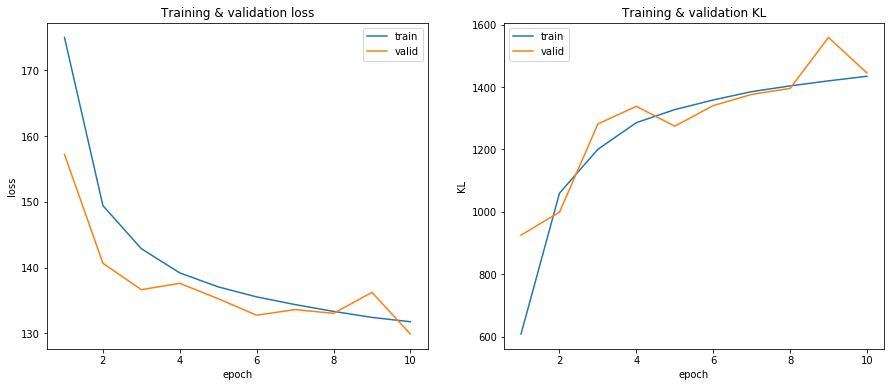

In [102]:
net.eval()

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
x = range(1, epoch + 2)
sns.lineplot(x=x, y=train_loss, ax=ax[0], label="train")
sns.lineplot(x=x, y=valid_loss, ax=ax[0], label="valid")
ax[0].set(xlabel="epoch",
          ylabel="loss",
          title="Training & validation loss")

sns.lineplot(x=x, y=train_kl, ax=ax[1], label="train")
sns.lineplot(x=x, y=valid_kl, ax=ax[1], label="valid")
ax[1].set(xlabel="epoch",
          ylabel="KL",
          title="Training & validation KL")

### Latent space visualization

In [103]:
images.shape

torch.Size([64, 1, 28, 28])

In [104]:
from sklearn.decomposition import PCA

agg_mu = torch.tensor([])
agg_mu_1 = []
agg_mu_2 = []
agg_l = []

with torch.no_grad():
    it = iter(test_loader)
    for i in range(50):
        images, labels = next(it)
        x = images.view(images.shape[0], -1)
        latent_mu, _ = torch.chunk(net.encoder(x), 2, dim=-1)
        agg_mu = torch.cat((agg_mu, latent_mu), dim=0)
        if latent_mu.shape[1] > 2:
            latent_mu = PCA(n_components=2).fit_transform(latent_mu.numpy())
        agg_mu_1 += list(latent_mu[:,0])
        agg_mu_2 += list(latent_mu[:,1])
        agg_l += list(labels.numpy())

# pom_images, pom_labels = next(iter(test_loader))
# pom_images.shape, pom_labels.shape
len(agg_mu_1), len(agg_mu_2), len(agg_l), agg_mu.shape

(3200, 3200, 3200, torch.Size([3200, 50]))

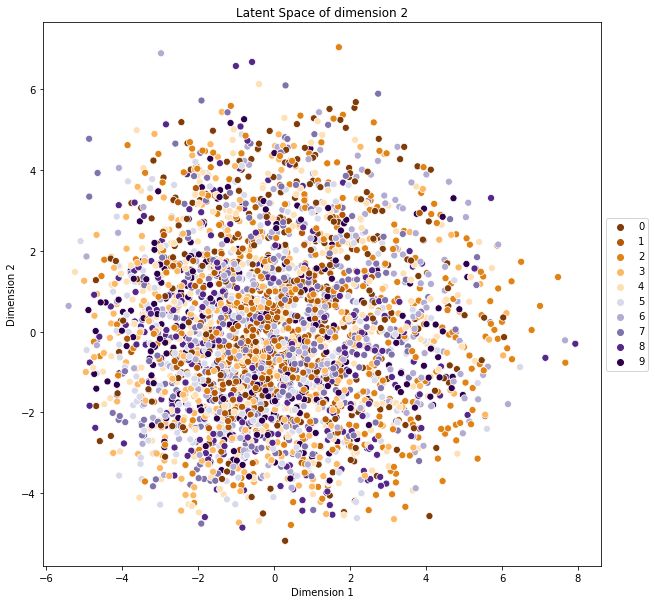

In [105]:
colors = ['#7f3b08','#b35806','#e08214','#fdb863','#fee0b6','#d8daeb','#b2abd2','#8073ac','#542788','#2d004b']
pal = sns.color_palette(colors)

f, ax = plt.subplots(1, figsize=(10,10))
sns.scatterplot(ax=ax, x=agg_mu_1, y=agg_mu_2, hue=agg_l, palette=pal, s=50)
ax.set_title('Latent Space of dimension 2')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

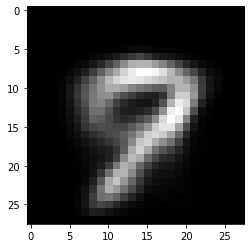

In [116]:
with torch.no_grad():
    z = torch.tensor(np.random.randn(1,50), dtype=torch.float32)
#     print(z.shape)
    plt.imshow(torch.sigmoid(net.decoder(z)).view(28,28), cmap='gist_gray')

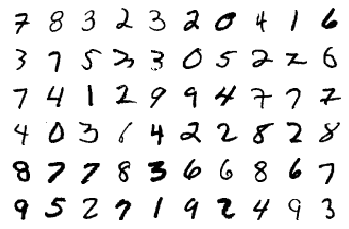

In [118]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

/home/lukas/anaconda3/envs/thesis-env/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


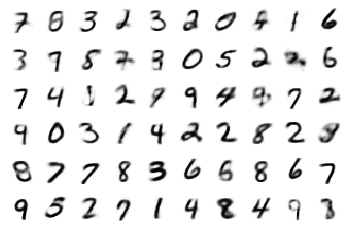

In [119]:
with torch.no_grad():
    x_hat, mu, log_var, z = net(images)
    figure = plt.figure()
    num_of_images = 60
    for index in range(1, num_of_images + 1):
        plt.subplot(6, 10, index)
        plt.axis('off')
        plt.imshow(x_hat[index].numpy().squeeze(), cmap='gray_r')

# Multinomial regression

In [169]:
# This code is inspired by MNIST classfification using multinomial logistic + L1, available at
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html
from sklearn.linear_model import LogisticRegression

train_samples = len(labeled_indices)

with torch.no_grad():
    net.eval()
    X_train = full_train_set.data[labeled_indices]
    X_train = X_train.view(X_train.shape[0], -1)
    X_train = net.encoder(X_train.float())[:,:50]

y_train = full_train_set.targets[labeled_indices]

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50. / train_samples,
                         multi_class='multinomial',
                         penalty='l1', solver='saga', tol=0.1)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100

# Test the performance on the labeled test data
X_test, y_test = next(iter(test_loader))
with torch.no_grad():
    net.eval()
    X_test = X_test.view(X_test.shape[0], -1)
    X_test = net.encoder(X_test.float())[:,:50]
score = clf.score(X_test, y_test)

print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)
# print(clf.coef_)

Sparsity with L1 penalty: 0.00%
Test score with L1 penalty: 0.6719
